In [1]:
import pandas as pd
import ast
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
import string 
from pandas.core.frame import DataFrame
import seaborn as sns

In [2]:
# read dataset.csv
df = pd.read_csv("Regional.csv",sep=';', encoding ='utf-8')
df['tags'][100]
df

,categorize,recipe_name,tags,avg_score,difficulty,ingredient,rating_count,calorie,preparation_time,comment_user,recipe_url
0,Regional,Hummus bi Tahin,"['Gemüse', 'Vorspeise', 'kalt', 'Vegetarisch',...",3.5,simpel,"['400g', 'Kichererbsen,vorgekocht', '100g', 'S...",4,80kcal,15 Min,"[{'rating': 'rating-5', 'comment_time': '08.04...",https://www.chefkoch.de/rezepte/20406813304436...
1,Regional,Pizza bianca,"['Hauptspeise', 'Backen', 'Italien', 'Europa',...",3.5,normal,"['400g', 'Mehl', '6EL', 'Sonnenblumenöl,oderDi...",2,NaN,30 Min,"[{'rating': 'rating-4', 'comment_time': '18.03...",https://www.chefkoch.de/rezepte/24193413819063...
2,Regional,Bibbeleskäse,"['Sommer', 'Europa', 'Vegetarisch', 'Deutschla...",3.5,simpel,"['1.000g', 'Quark', '1Becher', 'Sahne', '1', '...",2,NaN,20 Min,"[{'rating': 'rating-5', 'comment_time': '15.05...",https://www.chefkoch.de/rezepte/22088613538797...
3,Regional,Peixe pescador com grão de bico,"['Hauptspeise', 'Europa', 'Fisch', 'Dünsten', ...",3.5,normal,"['400g', 'Kichererbsen,überNachteingeweicht', ...",2,NaN,20 Min,"[{'rating': 'rating-5', 'comment_time': '09.03...",https://www.chefkoch.de/rezepte/60061115979627...
4,Regional,Bienenstich mit Sahne - Galetta - Füllung,"['Backen', 'Europa', 'Deutschland', 'Torte']",3.5,normal,"['4', 'Ei(er)', '200g', 'Zucker', '100g', 'Meh...",2,NaN,60 Min,"[{'rating': 'rating-4', 'comment_time': '11.05...",https://www.chefkoch.de/rezepte/61487116152025...
...,...,...,...,...,...,...,...,...,...,...,...
22796,Regional,Bananen - Walnuss - Muffins,"['Backen', 'USAoderKanada', 'Kuchen']",3.6,normal,"['330g', 'Mehl', '1TL', 'Backpulver', '1Prise(...",8,NaN,20 Min,"[{'rating': 'rating-2', 'comment_time': '12.08...",https://www.chefkoch.de/rezepte/10117112063493...
22797,Regional,Putengeschnetzeltes in Mango - Bananen - Kokos...,"['Asien', 'Hauptspeise', 'Schnell', 'einfach',...",3.6,simpel,"['500g', 'Putenfleisch,geschnetzelt', 'n.B.', ...",3,340kcal,30 Min,"[{'rating': 'rating-5', 'comment_time': '28.04...",https://www.chefkoch.de/rezepte/10359912087582...
22798,Regional,Bananen - Pancakes,"['USAoderKanada', 'Frühstück', 'Braten', 'Süßs...",3.6,simpel,"['125g', 'Mehl,gesiebt', '1EL', 'Zucker', '2TL...",3,NaN,5 Min,"[{'rating': 'rating-3', 'comment_time': '13.08...",https://www.chefkoch.de/rezepte/13397512388012...
22799,Regional,Chicken - Curry mit Banane,"['Indien', 'Asien', 'Hauptspeise', 'Geflügel',...",3.6,normal,"['4große', 'Hühnerschenkel', '3', 'Zwiebel(n)'...",3,NaN,25 Min,"[{'rating': 'rating-4', 'comment_time': '16.09...",https://www.chefkoch.de/rezepte/13737212422903...


In [3]:
def remove_item(data, name):
    y = data[data[name] =='[]']
    index_r = y.index.tolist()
    data = data.drop(index = index_r)
    return data

In [4]:
def remove_null(data, name):
    y = data[data[name] =='0']
    index_n = y.index.tolist()
    data = data.drop(index = index_n)
    return data

In [5]:
def tags_preprocess(tags):
    tags = tags.replace("'","")
    tags = tags.replace(" ","")
    tags = tags.replace("[","")
    tags = tags.replace("]","")
    tags = tags.split(",")
    tags = [x.lower() for x in tags]
    return tags

In [6]:
# check the null value in the dataset
print(pd.isnull(df))

       categorize  recipe_name   tags  avg_score  difficulty  ingredient  \
0           False        False  False      False       False       False   
1           False        False  False      False       False       False   
2           False        False  False      False       False       False   
3           False        False  False      False       False       False   
4           False        False  False      False       False       False   
...           ...          ...    ...        ...         ...         ...   
22796       False        False  False      False       False       False   
22797       False        False  False      False       False       False   
22798       False        False  False      False       False       False   
22799       False        False  False      False       False       False   
22800       False        False  False      False       False       False   

       rating_count  calorie  preparation_time  comment_user  recipe_url  
0           

In [13]:
# data preprossing
# delete all the [] in every column
df = df.drop_duplicates(['recipe_url'])
df = remove_item(df, 'recipe_url')
df = remove_item(df, 'tags')
df = remove_item(df, 'comment_user')
df.shape

# extract all the values from calorie and preparation time column
pat = r"([-+]?\d*\.\d+|\d+)"
df["pre_time"] = df["preparation_time"].str.extract(pat, flags=0, expand=True)
df["calorie_value"] = df["calorie"].str.extract(pat, flags=0, expand=True)


,level_0,index,categorize,recipe_name,tags,avg_score,difficulty,ingredient,rating_count,calorie,preparation_time,comment_user,recipe_url,region,pre_time,calorie_value
0,0,0,Regional,Hummus bi Tahin,"['Gemüse', 'Vorspeise', 'kalt', 'Vegetarisch',...",3.5,simpel,"['400g', 'Kichererbsen,vorgekocht', '100g', 'S...",4,80kcal,15 Min,"[{'rating': 'rating-5', 'comment_time': '08.04...",https://www.chefkoch.de/rezepte/20406813304436...,mittlerer & naher osten,15,80
1,1,1,Regional,Pizza bianca,"['Hauptspeise', 'Backen', 'Italien', 'Europa',...",3.5,normal,"['400g', 'Mehl', '6EL', 'Sonnenblumenöl,oderDi...",2,NaN,30 Min,"[{'rating': 'rating-4', 'comment_time': '18.03...",https://www.chefkoch.de/rezepte/24193413819063...,europa,30,NaN
2,2,2,Regional,Bibbeleskäse,"['Sommer', 'Europa', 'Vegetarisch', 'Deutschla...",3.5,simpel,"['1.000g', 'Quark', '1Becher', 'Sahne', '1', '...",2,NaN,20 Min,"[{'rating': 'rating-5', 'comment_time': '15.05...",https://www.chefkoch.de/rezepte/22088613538797...,europa,20,NaN
3,3,3,Regional,Peixe pescador com grão de bico,"['Hauptspeise', 'Europa', 'Fisch', 'Dünsten', ...",3.5,normal,"['400g', 'Kichererbsen,überNachteingeweicht', ...",2,NaN,20 Min,"[{'rating': 'rating-5', 'comment_time': '09.03...",https://www.chefkoch.de/rezepte/60061115979627...,europa,20,NaN
4,4,4,Regional,Bienenstich mit Sahne - Galetta - Füllung,"['Backen', 'Europa', 'Deutschland', 'Torte']",3.5,normal,"['4', 'Ei(er)', '200g', 'Zucker', '100g', 'Meh...",2,NaN,60 Min,"[{'rating': 'rating-4', 'comment_time': '11.05...",https://www.chefkoch.de/rezepte/61487116152025...,europa,60,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20377,20377,22796,Regional,Bananen - Walnuss - Muffins,"['Backen', 'USAoderKanada', 'Kuchen']",3.6,normal,"['330g', 'Mehl', '1TL', 'Backpulver', '1Prise(...",8,NaN,20 Min,"[{'rating': 'rating-2', 'comment_time': '12.08...",https://www.chefkoch.de/rezepte/10117112063493...,amerika,20,NaN
20378,20378,22797,Regional,Putengeschnetzeltes in Mango - Bananen - Kokos...,"['Asien', 'Hauptspeise', 'Schnell', 'einfach',...",3.6,simpel,"['500g', 'Putenfleisch,geschnetzelt', 'n.B.', ...",3,340kcal,30 Min,"[{'rating': 'rating-5', 'comment_time': '28.04...",https://www.chefkoch.de/rezepte/10359912087582...,asien,30,340
20379,20379,22798,Regional,Bananen - Pancakes,"['USAoderKanada', 'Frühstück', 'Braten', 'Süßs...",3.6,simpel,"['125g', 'Mehl,gesiebt', '1EL', 'Zucker', '2TL...",3,NaN,5 Min,"[{'rating': 'rating-3', 'comment_time': '13.08...",https://www.chefkoch.de/rezepte/13397512388012...,amerika,5,NaN
20380,20380,22799,Regional,Chicken - Curry mit Banane,"['Indien', 'Asien', 'Hauptspeise', 'Geflügel',...",3.6,normal,"['4große', 'Hühnerschenkel', '3', 'Zwiebel(n)'...",3,NaN,25 Min,"[{'rating': 'rating-4', 'comment_time': '16.09...",https://www.chefkoch.de/rezepte/13737212422903...,asien,25,NaN


In [14]:
# extract the recipe id from recipe urls
list_cat_no = []
i = 0
for item in df['recipe_url']:
    list_cat_no.append(item.split('/')[4])

# add one column "recipe_id" into the dataset and set it as the index of dataset
df['recipe_id'] = list_cat_no
df = df.set_index(["recipe_id"])
df

,level_0,index,categorize,recipe_name,tags,avg_score,difficulty,ingredient,rating_count,calorie,preparation_time,comment_user,recipe_url,region,pre_time,calorie_value
recipe_id,,,,,,,,,,,,,,,,
2040681330443605,0,0,Regional,Hummus bi Tahin,"['Gemüse', 'Vorspeise', 'kalt', 'Vegetarisch',...",3.5,simpel,"['400g', 'Kichererbsen,vorgekocht', '100g', 'S...",4,80kcal,15 Min,"[{'rating': 'rating-5', 'comment_time': '08.04...",https://www.chefkoch.de/rezepte/20406813304436...,mittlerer & naher osten,15,80
2419341381906336,1,1,Regional,Pizza bianca,"['Hauptspeise', 'Backen', 'Italien', 'Europa',...",3.5,normal,"['400g', 'Mehl', '6EL', 'Sonnenblumenöl,oderDi...",2,NaN,30 Min,"[{'rating': 'rating-4', 'comment_time': '18.03...",https://www.chefkoch.de/rezepte/24193413819063...,europa,30,NaN
2208861353879796,2,2,Regional,Bibbeleskäse,"['Sommer', 'Europa', 'Vegetarisch', 'Deutschla...",3.5,simpel,"['1.000g', 'Quark', '1Becher', 'Sahne', '1', '...",2,NaN,20 Min,"[{'rating': 'rating-5', 'comment_time': '15.05...",https://www.chefkoch.de/rezepte/22088613538797...,europa,20,NaN
600611159796275,3,3,Regional,Peixe pescador com grão de bico,"['Hauptspeise', 'Europa', 'Fisch', 'Dünsten', ...",3.5,normal,"['400g', 'Kichererbsen,überNachteingeweicht', ...",2,NaN,20 Min,"[{'rating': 'rating-5', 'comment_time': '09.03...",https://www.chefkoch.de/rezepte/60061115979627...,europa,20,NaN
614871161520252,4,4,Regional,Bienenstich mit Sahne - Galetta - Füllung,"['Backen', 'Europa', 'Deutschland', 'Torte']",3.5,normal,"['4', 'Ei(er)', '200g', 'Zucker', '100g', 'Meh...",2,NaN,60 Min,"[{'rating': 'rating-4', 'comment_time': '11.05...",https://www.chefkoch.de/rezepte/61487116152025...,europa,60,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011711206349324,20377,22796,Regional,Bananen - Walnuss - Muffins,"['Backen', 'USAoderKanada', 'Kuchen']",3.6,normal,"['330g', 'Mehl', '1TL', 'Backpulver', '1Prise(...",8,NaN,20 Min,"[{'rating': 'rating-2', 'comment_time': '12.08...",https://www.chefkoch.de/rezepte/10117112063493...,amerika,20,NaN
1035991208758269,20378,22797,Regional,Putengeschnetzeltes in Mango - Bananen - Kokos...,"['Asien', 'Hauptspeise', 'Schnell', 'einfach',...",3.6,simpel,"['500g', 'Putenfleisch,geschnetzelt', 'n.B.', ...",3,340kcal,30 Min,"[{'rating': 'rating-5', 'comment_time': '28.04...",https://www.chefkoch.de/rezepte/10359912087582...,asien,30,340
1339751238801256,20379,22798,Regional,Bananen - Pancakes,"['USAoderKanada', 'Frühstück', 'Braten', 'Süßs...",3.6,simpel,"['125g', 'Mehl,gesiebt', '1EL', 'Zucker', '2TL...",3,NaN,5 Min,"[{'rating': 'rating-3', 'comment_time': '13.08...",https://www.chefkoch.de/rezepte/13397512388012...,amerika,5,NaN


In [12]:
# tags propressing
# use the names of all regions to replace the tags
df.reset_index(inplace = True)
df['region'] = None
for i in range(len(df)):   
    tags = df.loc[i]['tags']
    tags = tags_preprocess(tags)
#     print(tags)
    if "europa" in tags:
        df.at[i,'region'] ='europa'
    if "afrika" in tags:
        df.at[i,'region'] ='afrika'
    if "asien" in tags:
        df.at[i,'region'] ='asien'
    if "amerika" in tags:
        df.at[i,'region'] ='amerika'
    if "australien" in tags:
        df.at[i,'region'] ='australien'
    if "karibikundexotik" in tags:
        df.at[i,'region'] ='karibik & exotik'
    if "mittlerer-undnaherosten" in tags:
        df.at[i,'region'] ='mittlerer & naher osten'
    if "osteuropa" in tags:
        df.at[i,'region'] ='osteuropa'
    if "usaoderkanada" in tags:
        df.at[i,'region'] ='amerika'
df

,level_0,index,categorize,recipe_name,tags,avg_score,difficulty,ingredient,rating_count,calorie,preparation_time,comment_user,recipe_url,region
0,0,0,Regional,Hummus bi Tahin,"['Gemüse', 'Vorspeise', 'kalt', 'Vegetarisch',...",3.5,simpel,"['400g', 'Kichererbsen,vorgekocht', '100g', 'S...",4,80kcal,15 Min,"[{'rating': 'rating-5', 'comment_time': '08.04...",https://www.chefkoch.de/rezepte/20406813304436...,mittlerer & naher osten
1,1,1,Regional,Pizza bianca,"['Hauptspeise', 'Backen', 'Italien', 'Europa',...",3.5,normal,"['400g', 'Mehl', '6EL', 'Sonnenblumenöl,oderDi...",2,NaN,30 Min,"[{'rating': 'rating-4', 'comment_time': '18.03...",https://www.chefkoch.de/rezepte/24193413819063...,europa
2,2,2,Regional,Bibbeleskäse,"['Sommer', 'Europa', 'Vegetarisch', 'Deutschla...",3.5,simpel,"['1.000g', 'Quark', '1Becher', 'Sahne', '1', '...",2,NaN,20 Min,"[{'rating': 'rating-5', 'comment_time': '15.05...",https://www.chefkoch.de/rezepte/22088613538797...,europa
3,3,3,Regional,Peixe pescador com grão de bico,"['Hauptspeise', 'Europa', 'Fisch', 'Dünsten', ...",3.5,normal,"['400g', 'Kichererbsen,überNachteingeweicht', ...",2,NaN,20 Min,"[{'rating': 'rating-5', 'comment_time': '09.03...",https://www.chefkoch.de/rezepte/60061115979627...,europa
4,4,4,Regional,Bienenstich mit Sahne - Galetta - Füllung,"['Backen', 'Europa', 'Deutschland', 'Torte']",3.5,normal,"['4', 'Ei(er)', '200g', 'Zucker', '100g', 'Meh...",2,NaN,60 Min,"[{'rating': 'rating-4', 'comment_time': '11.05...",https://www.chefkoch.de/rezepte/61487116152025...,europa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20377,20377,22796,Regional,Bananen - Walnuss - Muffins,"['Backen', 'USAoderKanada', 'Kuchen']",3.6,normal,"['330g', 'Mehl', '1TL', 'Backpulver', '1Prise(...",8,NaN,20 Min,"[{'rating': 'rating-2', 'comment_time': '12.08...",https://www.chefkoch.de/rezepte/10117112063493...,amerika
20378,20378,22797,Regional,Putengeschnetzeltes in Mango - Bananen - Kokos...,"['Asien', 'Hauptspeise', 'Schnell', 'einfach',...",3.6,simpel,"['500g', 'Putenfleisch,geschnetzelt', 'n.B.', ...",3,340kcal,30 Min,"[{'rating': 'rating-5', 'comment_time': '28.04...",https://www.chefkoch.de/rezepte/10359912087582...,asien
20379,20379,22798,Regional,Bananen - Pancakes,"['USAoderKanada', 'Frühstück', 'Braten', 'Süßs...",3.6,simpel,"['125g', 'Mehl,gesiebt', '1EL', 'Zucker', '2TL...",3,NaN,5 Min,"[{'rating': 'rating-3', 'comment_time': '13.08...",https://www.chefkoch.de/rezepte/13397512388012...,amerika
20380,20380,22799,Regional,Chicken - Curry mit Banane,"['Indien', 'Asien', 'Hauptspeise', 'Geflügel',...",3.6,normal,"['4große', 'Hühnerschenkel', '3', 'Zwiebel(n)'...",3,NaN,25 Min,"[{'rating': 'rating-4', 'comment_time': '16.09...",https://www.chefkoch.de/rezepte/13737212422903...,asien


In [ ]:
# # Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = 'afrika', 'amerika', 'asien', 'australien','europa','karibik & exotik','mittlerer & naher osten','osteuropa'
# sizes = group_region['recipe_name']
# explode = (0, 0, 0, 0, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, explode=explode, autopct='%1.1f%%',
#         shadow=True, startangle=90)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# ax.legend(labels,
#           title="Ingredients",
#           loc="center left",
#           bbox_to_anchor=(1, 0, 0.5, 1))

# ax.set_title("Matplotlib bakery: A pie")

# plt.show()

In [ ]:
# divide the dataset into different region groups
group_region = df.groupby('region').count()
data_region = pd.DataFrame(group_region['recipe_name'])
data_region

In [ ]:
x = [u'afrika', u'amerika', u'asien', u'australien', u'europa', u'karibik & exotik', u'mittlerer & naher osten', u'osteuropa']
y = data_region['recipe_name']
fig, ax = plt.subplots(figsize=(8, 5))    

width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('the number of recipes in different regions')
plt.xlabel('Amount of recipes')
plt.ylabel('Regions')
plt.show()

In [16]:
# delete the recipes, which have no average score.
# df_avg = remove_null(df,'avg_score')
# df_avg

# avg_count = df_avg['avg_score'].value_counts()
# df_avg_count = avg_count.to_frame()
# df_avg_coun

list_score = avg_count.index.tolist()
list_score
d = df_avg['avg_score'].value_counts()
list_count = d.values.tolist()
list_count

[1807,
 1509,
 1071,
 978,
 692,
 554,
 547,
 454,
 451,
 384,
 263,
 258,
 257,
 189,
 179,
 161,
 154,
 150,
 149,
 148,
 124,
 124,
 119,
 117,
 116,
 104,
 103,
 99,
 99,
 98,
 98,
 90,
 89,
 87,
 87,
 82,
 80,
 79,
 78,
 72,
 70,
 70,
 64,
 64,
 63,
 63,
 61,
 61,
 61,
 61,
 59,
 59,
 58,
 57,
 56,
 56,
 55,
 54,
 52,
 52,
 52,
 51,
 50,
 50,
 49,
 47,
 44,
 43,
 43,
 40,
 40,
 39,
 36,
 35,
 34,
 34,
 34,
 32,
 31,
 31,
 31,
 30,
 30,
 30,
 29,
 29,
 29,
 29,
 29,
 28,
 28,
 28,
 28,
 27,
 27,
 27,
 26,
 25,
 25,
 25,
 25,
 24,
 23,
 23,
 22,
 21,
 21,
 21,
 21,
 19,
 19,
 18,
 18,
 17,
 16,
 16,
 16,
 16,
 16,
 13,
 12,
 12,
 11,
 10,
 9,
 9,
 8,
 8,
 8,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

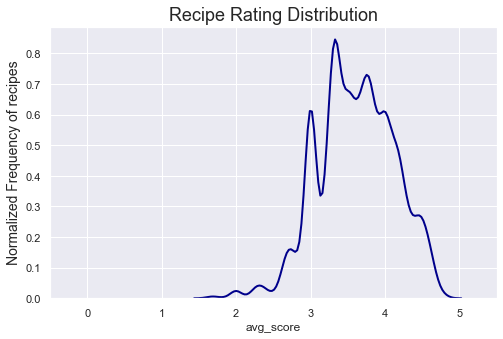

In [15]:
plt.figure(figsize=(8, 5))
sns.set()
sns.distplot(df_avg['avg_score'],hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

# sns.distplot(df_avg['avg_score'], hist=True, kde=False, 
#              bins=int(180/5), color = 'blue',
#              hist_kws={'edgecolor':'black'})

# plt.grid(linestyle='-.')
plt.title('Recipe Rating Distribution', fontsize=18)
plt.xlim(-0.5,5.5,0.8)
plt.ylabel('Normalized Frequency of recipes',fontsize=14)
plt.show()